In [1]:
import numpy as np
import math
import csv
from proj1_helpers import *
from Hadrien import *
from ML_methods import *
from features_engineering import *
from correlation import *
import matplotlib.pyplot as plt
from NAN_Pattern_Decomposition import decompose_dataset_according_to_NAN_pattern


%load_ext autoreload
%autoreload 2

### load Data

In [295]:
y, tx, ids = load_csv_data("data_csv/train.csv", sub_sample=False)
print("y has shape {0}".format(y.shape))
print("X has shape {0}".format(tx.shape))

y has shape (250000,)
X has shape (250000, 30)


-> we can observe some (3 at all) different patterns of NAN values -> essayer de déterminer si ces values ont une corrélation avec le label:
- pattern 1: feature 0: 840 NAN -> 16.8% NAN
- pattern 2: features 23,24,25: 1985 NAN -> 39.7% NAN
- pattern 3: features 4,5,6,12,26,27,28: 3525 NAN -> 70.5 % NAN


Also :
- 562 samples de p1 font parti de p2.
- 734 samples de p1 font parti de p3.
- 0 samples de p2 font parti de p1.
- 1423 sample de p2 font parti de p3
- 0 samples de p3 font parti de p1.
- 0 samples de p3 font parti de p2.

Also:
- p2 inter p3 = 1985
- p1 union p3 union p2 = 3631

In [296]:
tx_nan = transform_to_nan(tx, -900)

In [297]:
def transform_column_22_and_delete(tx_nan):
    
    txx = tx_nan.copy()

    #ajoute des vecteurs booleens pour chaque valeur (0.0, 1.0, 2.0 ou 3.0) de la feature 22
    tx0 = new_feature_PRI_jet_num(txx, 0.0)
    tx1 = new_feature_PRI_jet_num(tx0, 1.0)
    tx2 = new_feature_PRI_jet_num(tx1, 2.0)
    tx3 = new_feature_PRI_jet_num(tx2, 3.0)

    #enlever la colonne de la feature 22 with "delete(matrice, indice, colonne = 1)"
    tx3_final = np.delete(tx3, 22, 1)

    return tx3_final.copy()

In [298]:
def remove_constant_features(x, cols):
    return np.delete(x, cols, axis = 1)

In [299]:
xx = transform_column_22_and_delete(tx_nan)

In [300]:
def transform_column_22_and_delete(tx_nan):
    
    txx = tx_nan.copy()

    #ajoute des vecteurs booleens pour chaque valeur (0.0, 1.0, 2.0 ou 3.0) de la feature 22
    tx0 = new_feature_PRI_jet_num(txx, 0.0)
    tx1 = new_feature_PRI_jet_num(tx0, 1.0)
    tx2 = new_feature_PRI_jet_num(tx1, 2.0)
    tx3 = new_feature_PRI_jet_num(tx2, 3.0)

    #enlever la colonne de la feature 22 with "delete(matrice, indice, colonne = 1)"
    tx3_final = np.delete(tx3, 22, 1)

    return tx3_final.copy()

In [301]:
p0_ind, p0, y0, p1_ind, p1, y1, p2_ind, p2, y2, p3_ind, p3, y3 = decompose_dataset_according_to_NAN_pattern(xx, y, [0,23,27])

In [118]:
feature_nans_1 = [0]
p1_processed = remove_constant_features(p1, feature_nans_1)

feature_nans_2 = [4, 5, 6, 12, 22, 23, 24, 25, 26, 27]
p2_processed = remove_constant_features(p2, feature_nans_2)

feature_nans_3 = [4, 5, 6, 12, 25, 26, 27]
p3_processed = remove_constant_features(p3, feature_nans_3)

In [248]:
p0_nan_mean, p0_mean =transform_to_mean(p0)
p1_nan_mean, p1_mean =transform_to_mean(p1_processed)
p2_nan_mean, p2_mean =transform_to_mean(p2_processed)
p3_nan_mean, p3_mean =transform_to_mean(p3_processed)

# Feature Engineering

In [65]:
def basic_features_process(tx):
    
    tx_nan_mean, nan_mean = transform_to_mean(tx)
    
    features_square = [6]
    tx_square = transform_feature_power(tx_nan_mean, features_square, 2)

    features_log = [0, 2, 3, 5, 6, 8, 9, 10, 13, 16, 19, 21, 23, 26, 29]
    tx_log = transform_feature_log(tx_square, features_log)

    features_sin = [11, 12, 14, 15, 17]
    tx_angle_stand = standardize_angles(tx_log, features_sin)
    tx_sin = transform_feature_sin(tx_angle_stand, features_sin)

    feature_std = features_log
    tx_std, mean, std = standardize_features(tx_sin, feature_std)

    tx_22plus0 = new_feature_PRI_jet_num(tx_std, 0.0)
    tx_22plus1 = new_feature_PRI_jet_num(tx_22plus0, 1.0)
    tx_22plus2 = new_feature_PRI_jet_num(tx_22plus1, 2.0)
    tx_22plus3 = new_feature_PRI_jet_num(tx_22plus2, 3.0)
    
    return tx_22plus3, nan_mean



In [103]:
def create_big_matrix_with_transformations(dataset):
    
    tx_ = dataset.copy()
    (l,c) = np.shape(dataset)
    features = list(range(c))
    #features = list(range(30-1))   #-1 car on a enleve la colonne 22     

    # ajouter sin
    tx_sin = transform_feature_sin(tx_, features)

    #ajouter cos
    tx_cos = transform_feature_cos(tx_sin, features)

    #ajouter log
    tx_log, log_min = transform_feature_log(tx_cos, features)

    #ajouter sqrt
    tx_sqrt, sqrt_min = transform_feature_sqrt(tx_log, features)
    
    ## Put nan values to 0 if some where below zero before sqrt and log
    #tx_zero_nan = transform_nan_to_zero(tx_sqrt)
    
    #standardize
    tx_stand, tx_mean, tx_std = standardize(tx_sqrt)
    
    dataset_eng = tx_stand.copy()
    
    return dataset_eng, log_min, sqrt_min

In [67]:
def select_best_features(tx_big, w_big,  nb_cols, nb_transform):
    #garder les meilleurs weight pour chaque feature 
    w = w_big.copy()
    w_best = np.zeros(nb_cols)
    indices_good_features = np.zeros(nb_cols)
    print(len(w))
    w_best[0] = w[0]
    liste = list(range(1, nb_cols))
    transformation = list(range(nb_transform))
    for i in liste:
        col = i
        for j in transformation:
            #si on en est à la première transformation -> initialiser le premier élément de w à cette valeur
            if(j == 0):
                w_best[i] = w[col]
                indices_good_features[i] = col
            elif(w[col] > w_best[j]):
                w_best[i] = w[col]
                indices_good_features[i] = col
            col = (j*(nb_cols-1))+i

    print(indices_good_features)

    #reconstruire nouvelle matrice
    f = len(indices_good_features)
    (l,c) = tx_big.shape
    p_best_final = np.zeros((l, f))
    
    
    for indice, col in enumerate(np.int0(indices_good_features)):
        p_best_final[:,indice] =  tx_big[:, col]
        
    return p_best_final, indices_good_features

## Pattern 0 (No NAN values)

In [168]:
def test_with_lsgd(tx, y, ratio = 0.8, batch = 10, max_iter = 20000, gamma = 0.01):
    
    x_tr, x_te, y_tr, y_te = split_data(tx, y, ratio)

    initial_w_gd = np.zeros(tx.shape[1])

    gd_l,gd_w = log_stochastic_gradient_descent(y_tr, x_tr, initial_w_gd, batch, max_iter, gamma)

    l,wnew=minimum_loss_vector(gd_l, gd_w)
    
    y_pred = predict_labels(wnew , x_te)
    accur = accuracy_calculator(y_pred, y_te)
    
    print("Accuracy : {0}".format(accur))
    
    return l, wnew

In [95]:
def find_best_transformations(tx, y, nb_cols, nb_transform, batch_size, max_iter, gama):
    losses, ws = log_stochastic_gradient_descent(y, tx, np.zeros(tx.shape[1]), batch_size, max_iter, gama)
    #si converge -> dernier w qui est le meilleur: 
    ws_best = ws[-1]
    tx_best = select_best_features(tx, ws_best, nb_cols, nb_transform)
    return tx_best

In [70]:
def add_first_feature_column(tx):
    
    (l,c) = np.shape(tx)
    a = np.ones((l,1), float)
    tx_plus = np.c_[a, tx]
    return tx_plus

In [71]:
def create_polynomial(tx, features):
    tx = transform_feature_power(tx, features, 2 )
    tx = transform_feature_power(tx, features, 3 )
    return tx

In [72]:
def create_inter_product(tx, features_1, features_2):
    for i in range(len(features_2)):
        tx = transform_feature_inter_product(tx, [features_1[i], features_2[i]])
    return tx

In [121]:
p0_nan_mean_moins = remove_constant_features(p0_nan_mean, [29, 30])

In [202]:
p0_eng, log_min0, sqrt_min0 = create_big_matrix_with_transformations(p0_nan_mean_moins)

In [125]:
p0_eng_plus = add_first_feature_column(p0_eng)

In [128]:
p0_best_final, indices0_best = find_best_transformations(p0_eng_plus, y0, (p0_nan_mean_moins.shape[1] + 1), 4, 1, 1000, 1e-5)

SGD(0/999): loss=0.6931471805589208, w0=0.0, w1=0.0
SGD(200/999): loss=0.6917539461791284, w0=-9.000395536827729e-05, w1=-0.00012151059392038148
SGD(400/999): loss=0.6901733315155685, w0=-0.0001698854088668231, w1=-0.00014166482999719755
SGD(600/999): loss=0.6888342458843368, w0=-0.00015013485696516125, w1=-0.0001681343798900254
SGD(800/999): loss=0.6873168624410554, w0=-7.132939162892404e-05, w1=-0.00016507132324903226
SGD(999/999): loss=0.6861495517609283, w0=-0.00015548473079474208, w1=-0.0001529026610974403
156
[ 0. 63.  2.  3.  4. 67.  6. 69. 70. 71. 72. 11. 74. 75. 14. 15. 16. 79.
 18. 81. 82. 21. 22. 23. 86. 87. 26. 89. 28. 29. 92. 62.]


In [134]:
p0_polynomial = create_polynomial(p0_best_final, [5, 8, 13, 15, 18, 24])

In [135]:
p0_product = create_inter_product(p0_polynomial, [30, 30, 30, 30], [8, 16, 26, 1])

In [81]:
from train_model import *

Ridge Resgression, Loss : 0.723, Lambda : 1e-05


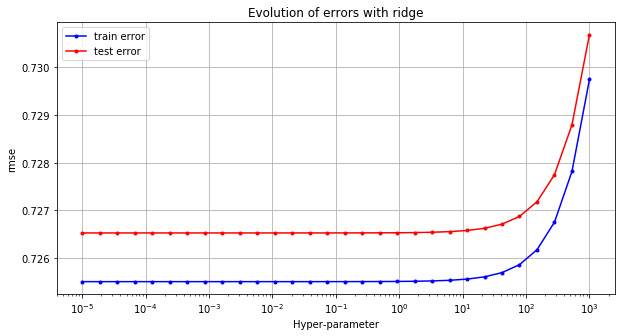

In [318]:
ridge_regression_exploration(y0, p0_product, 0.8, np.logspace(-5, 3, 30))


In [320]:
x_tr, x_te, y_tr, y_te = split_data(p0_product, y0, 0.8)
ws0_best = ridge_regression(y_tr, x_tr, 1e-5)
y_pred = predict_labels(ws0_best, x_te)
accuracy_calculator(y_pred, y_te)

0.7638552448065771

In [139]:
l, ws0 = test_with_lsgd(p0_product, y0)

SGD(0/19999): loss=0.6931471805590762, w0=0.0, w1=0.0
SGD(4000/19999): loss=0.49740456055205423, w0=0.24217559234182798, w1=0.020924317106825508
SGD(8000/19999): loss=0.4911301691317836, w0=0.3398767252430874, w1=0.009414370614756667
SGD(12000/19999): loss=0.490702330061443, w0=0.4638200991479741, w1=0.021742612735708478
SGD(16000/19999): loss=0.49007884179647104, w0=0.4985609544987854, w1=0.021675247870907008
SGD(19999/19999): loss=0.49004207586831405, w0=0.5344799333007126, w1=0.010308528635543338
Accuracy : 0.7645892975115613


In [141]:
x_tr, x_te, y_tr, y_te = split_data(p0_product, y0, 0.8)
y_pred = predict_labels(ws0 , x_te)
accur = accuracy_calculator(y_pred, y_te)
accur

0.7645892975115613

## Pattern 1 (Feature 0)

In [262]:
p1_nan_mean_moins = remove_constant_features(p1_nan_mean, [])

p1_eng, log_min1, sqrt_min1 = create_big_matrix_with_transformations(p1_nan_mean_moins)

p1_eng_plus = add_first_feature_column(p1_eng)

p1_best_final, indices1_best = find_best_transformations(p1_eng_plus, y1, p1_nan_mean_moins.shape[1] + 1, 4, 1, 1000, 1e-5)

#display_feature_distribution(y0, p0_best_final,  50)

p1_polynomial = create_polynomial(p1_best_final, [9, 15])

p1_product = create_inter_product(p1_polynomial, [29, 29, 29, 29, 29], [1, 10, 16, 24, 28])

p1_product.shape

SGD(0/999): loss=0.6931471805594103, w0=0.0, w1=0.0
SGD(200/999): loss=0.6927986765076527, w0=-0.0008997758999748945, w1=5.113108516661411e-05
SGD(400/999): loss=0.6922885546656435, w0=-0.001759121477178221, w1=-1.1674665189806691e-05
SGD(600/999): loss=0.6916897469452316, w0=-0.0026079319585984874, w1=-0.00018329761199025553
SGD(800/999): loss=0.6910714932788817, w0=-0.0033963838817683226, w1=-0.00027261418489523174
SGD(999/999): loss=0.6905783368755092, w0=-0.004239787683903415, w1=-0.00034484468337650536
161
[ 0. 65. 34. 35. 36.  5.  6.  7. 40. 41. 42. 75. 76. 13. 14. 47. 16. 49.
 50. 51. 20. 53. 54. 55. 56. 57. 90. 59. 60. 61. 62. 31. 32.]


(38114, 42)

Ridge Resgression, Loss : 0.245, Lambda : 11.721022975334794


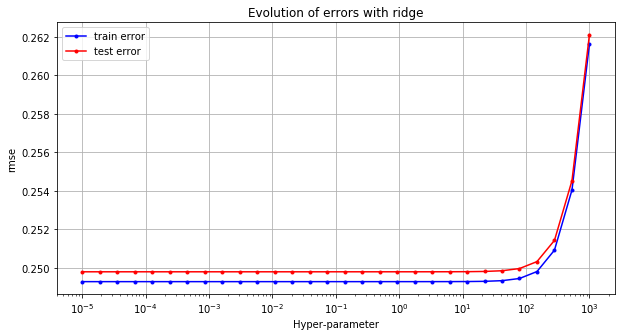

In [145]:
ridge_regression_exploration(y1, p1_product, 0.8, np.logspace(-5, 3, 30))

In [149]:
x_tr, x_te, y_tr, y_te = split_data(p1_product, y1, 0.8)
ws1_ridge = ridge_regression(y_tr, x_tr, 12)
y_pred = predict_labels(ws1_ridge, x_te)
accuracy_calculator(y_pred, y_te)

0.930604748786567

## Pattern 2 (Feature 23)

In [265]:
p2_nan_mean_moins = remove_constant_features(p2_nan_mean, [18, 19, 20, 21, 22])

p2_eng, log_min2, sqrt_min2 = create_big_matrix_with_transformations(p2_nan_mean_moins)

p2_eng_plus = add_first_feature_column(p2_eng)

p2_best_final, indices2_best = find_best_transformations(p2_eng_plus, y2, p2_nan_mean_moins.shape[1] + 1, 4, 1, 1000, 1e-5)

#display_feature_distribution(y0, p0_best_final,  50)

p2_polynomial = create_polynomial(p2_best_final, [2, 3, 5, 10, 13, 16, 18, 23])

p2_product = create_inter_product(p2_polynomial, [9, 9, 9, 9, 9, 9, 9, 9, 9], [5, 6, 10, 11, 12, 13, 14, 16, 23])

p2_product_log, min_square_log2 = transform_feature_log(p2_product, [28, 29, 30, 35])

p2_product_log.shape

SGD(0/999): loss=0.6931471805588729, w0=0.0, w1=0.0
SGD(200/999): loss=0.6921083624180955, w0=-0.0003298826473015914, w1=0.00010227034795248941
SGD(400/999): loss=0.6911421298921633, w0=-0.0007896322527587108, w1=0.00017492035608846445
SGD(600/999): loss=0.6901419431439946, w0=-0.001148730307483048, w1=0.00019448942748761372
SGD(800/999): loss=0.6892260024323404, w0=-0.001518150837292658, w1=0.0003655541541119456
SGD(999/999): loss=0.688246519039861, w0=-0.001991854364383313, w1=0.00021359682916914454
91
[ 0. 37. 38. 21.  4. 41.  6.  7. 26. 45. 46. 11. 12. 13. 14. 51. 16. 17.
 36.]


(73790, 48)

Ridge Resgression, Loss : 6.1, Lambda : 1000.0


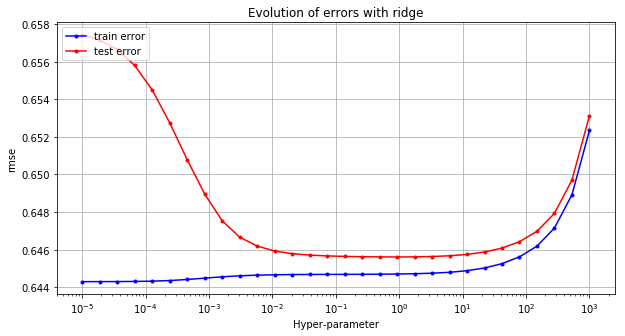

In [165]:
ridge_regression_exploration(y2, p2_product_log, 0.8, np.logspace(-5, 3, 30))

In [167]:
x_tr, x_te, y_tr, y_te = split_data(p2_product_log, y2, 0.8)
ws2_ridge = ridge_regression(y_tr, x_tr, 1e-1)
y_pred = predict_labels(ws2_ridge, x_te)
accuracy_calculator(y_pred, y_te)

0.7905542756471067

In [169]:
l, ws2_best = test_with_lsgd(p2_product_log, y2)

SGD(0/19999): loss=0.6931471805590165, w0=0.0, w1=0.0
SGD(4000/19999): loss=inf, w0=-1.9155316433739582, w1=-0.2514427672158787
SGD(8000/19999): loss=19265.826529746453, w0=0.07770607390472693, w1=-0.10063836644999169
SGD(12000/19999): loss=1444183.065075099, w0=0.4188228332366984, w1=-0.1454869507214358
SGD(16000/19999): loss=89121.70107060889, w0=0.21601342467700202, w1=0.06194150869493514
SGD(19999/19999): loss=405120.96331892716, w0=0.2187401590791687, w1=0.11402171205996718
Accuracy : 0.677937389890229


## Pattern 3 (Feature 28)

In [336]:
p3_nan_mean_moins = remove_constant_features(p3_nan_mean, [22, 23, 24, 25])

p3_eng, log_min3, sqrt_min3 = create_big_matrix_with_transformations(p3_nan_mean_moins)

p3_eng_plus = add_first_feature_column(p3_eng)

p3_best_final, indices3_best = find_best_transformations(p3_eng_plus, y3, p3_nan_mean_moins.shape[1] + 1, 4, 1, 1000, 1e-5)

p3_polynomial = create_polynomial(p3_best_final, [4, 5, 6, 8, 9, 18, 20])

p3_product = create_inter_product(p3_polynomial, [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [4, 5, 6, 8, 12, 13, 14, 16, 17, 18, 20, 21])

p3_product_log, min_square_log3 = transform_feature_log(p3_product, [23, 24, 26, 33])

p3_product_log.shape

SGD(0/999): loss=0.6931471805589041, w0=0.0, w1=0.0
SGD(200/999): loss=0.6924889244270381, w0=-0.00024987371492795463, w1=1.206944594706038e-06
SGD(400/999): loss=0.691940005180258, w0=-0.00037993588074600074, w1=3.0319741150615488e-05
SGD(600/999): loss=0.6914986650440126, w0=-0.0005897585800166478, w1=-2.189078692067857e-05
SGD(800/999): loss=0.6908261251430039, w0=-0.0007200711338697439, w1=0.00010535988025519823
SGD(999/999): loss=0.6903514854207651, w0=-0.0010342138277527058, w1=0.0001394221613952001
111
[ 0.  1.  2.  3.  4. 49.  6.  7.  8. 53. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 64. 21. 22.]


(69982, 53)

Ridge Resgression, Loss : 0.789, Lambda : 0.0008531678524172806


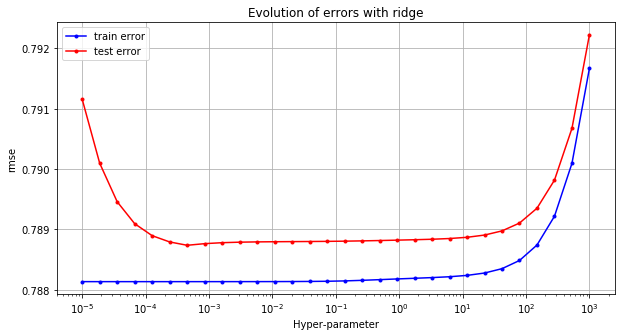

In [176]:
ridge_regression_exploration(y3, p3_product_log, 0.8, np.logspace(-5, 3, 30))

In [178]:
x_tr, x_te, y_tr, y_te = split_data(p3_product_log, y3, 0.8)
ws3_ridge = ridge_regression(y_tr, x_tr, 1e-1)
y_pred = predict_labels(ws3_ridge, x_te)
accuracy_calculator(y_pred, y_te)

0.7136529256269201

In [179]:
ws3, l3 = test_with_lsgd(p3_product_log, y3)

SGD(0/19999): loss=0.6931471805590554, w0=0.0, w1=0.0
SGD(4000/19999): loss=0.5629378406765672, w0=-0.006981700387083935, w1=0.13507339039590086
SGD(8000/19999): loss=0.5565996631442862, w0=-0.006279335463446568, w1=0.1993548576504776
SGD(12000/19999): loss=0.8231358063325055, w0=-0.0067794519701722886, w1=0.182432254414752
SGD(16000/19999): loss=0.553003670355126, w0=-0.0005471177189237157, w1=0.16897321384843597
SGD(19999/19999): loss=1.1167130394729097, w0=-0.007406469232593282, w1=0.1262805625696823
Accuracy : 0.7190826605701222


# Train Models 

In [189]:
from train_model import *
max_iter = 20000
batch_size = 10
initial_w = np.zeros(p0_product.shape[1])

## P0

SGD(0/19999): loss=0.6931471805590762, w0=0.0, w1=0.0
SGD(4000/19999): loss=0.542576312697776, w0=0.017243372275877692, w1=0.011963835560671461
SGD(8000/19999): loss=0.5237611320726167, w0=0.053228108498620176, w1=0.01995299795635334
SGD(12000/19999): loss=0.5154009059718276, w0=0.087515950458222, w1=0.02039127321575103
SGD(16000/19999): loss=0.509694652929416, w0=0.10795130856289853, w1=0.02466312084822682
SGD(19999/19999): loss=0.5056660656085386, w0=0.12781025875426522, w1=0.022563506736024495
SGD(0/19999): loss=0.6931471805590762, w0=0.0, w1=0.0
SGD(4000/19999): loss=0.5065021282077871, w0=0.15976981170345123, w1=0.02779407399106344
SGD(8000/19999): loss=0.4950082565314873, w0=0.2508737747022089, w1=0.021574769125999683
SGD(12000/19999): loss=0.4920181820647284, w0=0.3590213443718815, w1=0.03896031332798652
SGD(16000/19999): loss=0.49017263345112805, w0=0.3978315442600919, w1=0.013747898923447167
SGD(19999/19999): loss=0.4890113988266408, w0=0.44260392943238014, w1=0.01804895057994

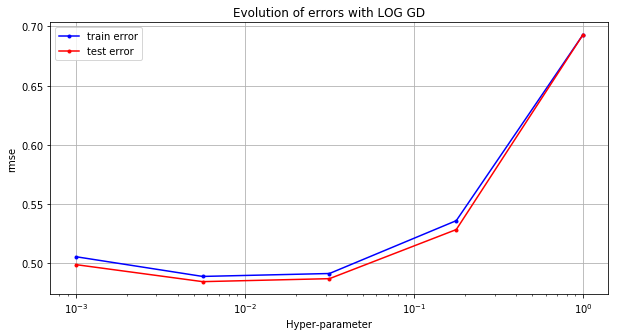

In [191]:
logistic_stochastic_gradient_descent_exploration(y0, p0_product, 0.8, np.logspace(-3, 0, 5), batch_size, initial_w, max_iter)

In [199]:
_, ws0_best = log_stochastic_gradient_descent(y0, p0_product, initial_w, 10, 20000, 5.6e-3)

SGD(0/19999): loss=0.6931471805589208, w0=0.0, w1=0.0
SGD(4000/19999): loss=0.5040207848555203, w0=0.15342887955224194, w1=0.034076748977626733
SGD(8000/19999): loss=0.4939906747744563, w0=0.243595279725571, w1=-0.001648291963714765
SGD(12000/19999): loss=0.4915871664850416, w0=0.33348568571048276, w1=0.01853538328868772
SGD(16000/19999): loss=0.48967001026667534, w0=0.39975478615140436, w1=0.06503724782799349
SGD(19999/19999): loss=0.4878338086983704, w0=0.4175687534326149, w1=0.039346839678896565


In [73]:
ws0_best = ws0_best[-1]

Ridge Resgression, Loss : 0.723, Lambda : 1e-10


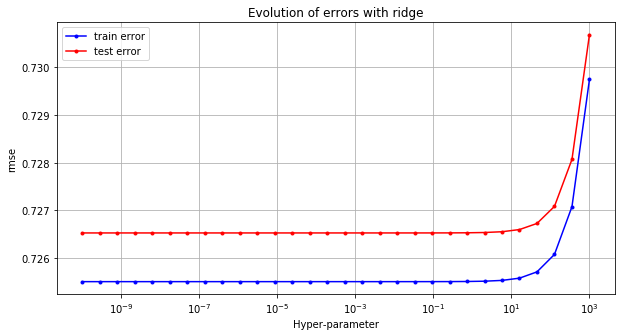

In [331]:
ridge_regression_exploration(y0, p0_product, 0.8, np.logspace(-10, 3, 30))

In [333]:
x_tr, x_te, y_tr, y_te = split_data(p0_product, y0, 0.8)
ws0_ridge = ridge_regression(y_tr, x_tr, 1e-5)
y_pred1 = predict_labels(ws0_ridge, x_te)
accuracy_calculator(y_pred1, y_te)

0.7638552448065771

## P1

Ridge Resgression, Loss : 0.246, Lambda : 1e-10


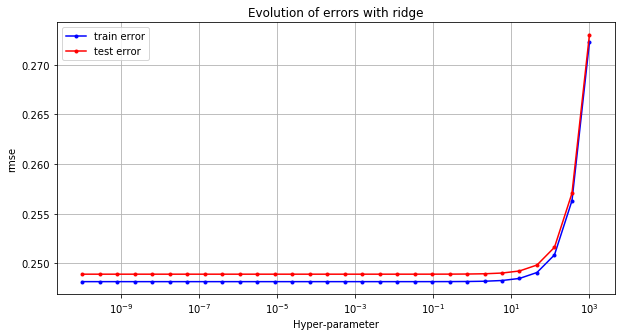

In [323]:
ridge_regression_exploration(y1, p1_product, 0.8, np.logspace(-10, 3, 30))

In [330]:
x_tr, x_te, y_tr, y_te = split_data(p1_product, y1, 0.8)
ws1_ridge = ridge_regression(y_tr, x_tr, 1e-5)
y_pred1 = predict_labels(ws1_ridge, x_te)
accuracy_calculator(y_pred1, y_te)

0.9273252000524728

## P2

Ridge Resgression, Loss : 5.067, Lambda : 10000.0


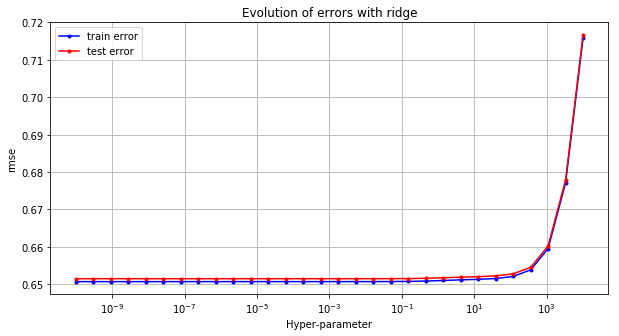

In [327]:
ridge_regression_exploration(y2, p2_product_log, 0.8, np.logspace(-10, 4, 30))

In [328]:
x_tr, x_te, y_tr, y_te = split_data(p2_product_log, y2, 0.8)
ws2_ridge = ridge_regression(y_tr, x_tr, 16)
y_pred2 = predict_labels(ws2_ridge, x_te)
accuracy_calculator(y_pred2, y_te)

0.7843881284726928

## P3

Ridge Resgression, Loss : 0.756, Lambda : 0.0017433288221999908


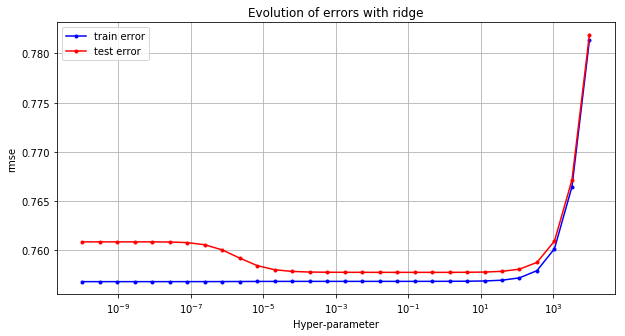

In [337]:
ridge_regression_exploration(y3, p3_product_log, 0.8, np.logspace(-10, 4, 30))

In [338]:
x_tr, x_te, y_tr, y_te = split_data(p3_product_log, y3, 0.8)
ws3_ridge = ridge_regression(y_tr, x_tr, 5.7e-4)
y_pred3 = predict_labels(ws3_ridge, x_te)
accuracy_calculator(y_pred3, y_te)

0.7358719725655498

# Test Models

In [244]:
y_te, tx_te, ids_te = load_csv_data("data_csv/test.csv", sub_sample=False)
print("y has shape {0}".format(y.shape))
print("X has shape {0}".format(tx.shape))

y has shape (250000,)
X has shape (250000, 30)


In [304]:
tx_te_nan = transform_to_nan(tx_te, -900)
xx_te = transform_column_22_and_delete(tx_te_nan)
p0_ind_te, p0_te, y0_te, p1_ind_te, p1_te, y1_te, p2_ind_te, p2_te, y2_te, p3_ind_te, p3_te, y3_te = decompose_dataset_according_to_NAN_pattern(xx_te, y_te, [0,23,27])

In [305]:
feature_nans_1 = [0]
p1_te_processed = remove_constant_features(p1_te, feature_nans_1)

feature_nans_2 = [4, 5, 6, 12, 22, 23, 24, 25, 26, 27]
p2_te_processed = remove_constant_features(p2_te, feature_nans_2)

feature_nans_3 = [4, 5, 6, 12, 25, 26, 27]
p3_te_processed = remove_constant_features(p3_te, feature_nans_3)

p0_te_nan_mean = transform_feature_to_mean_given_training(p0_te, p0_mean)
p1_te_nan_mean = transform_feature_to_mean_given_training(p1_te_processed, p1_mean)
p2_te_nan_mean = transform_feature_to_mean_given_training(p2_te_processed, p2_mean)
p3_te_nan_mean = transform_feature_to_mean_given_training(p3_te_processed, p3_mean)

In [306]:
feature_0_to_select = [0, 63, 2, 3, 4, 67, 6,  69, 70, 71, 72, 11, 74, 75, 14, 15, 16, 79,
 18, 81, 82, 21, 22, 23, 86, 87, 26, 89, 28, 29, 92, 62]
feature_0_poly = [5, 8, 13, 15, 18, 24]
feature_0_inter_product_1 = [30, 30, 30, 30]
feature_0_inter_product_2 = [8, 16, 26, 1]
feature_0_square_log = []

In [307]:
feature_1_to_select = [ 0, 65, 66, 67, 36,  5, 70, 71,  8,  9, 42, 75, 76, 13, 14, 79, 80, 17,
 82, 83, 20, 53, 86, 87, 88, 25, 90, 91, 92, 61, 94, 95, 96]
feature_1_poly = [9, 15]
feature_1_inter_product_1 =  [29, 29, 29, 29, 29]
feature_1_inter_product_2 = [1, 10, 16, 24, 28]
feature_1_square_log = []

In [308]:
feature_2_to_select = [ 0, 37, 38,  3,  4, 41,  6,  7, 26,  9, 28, 11, 12, 13, 14, 15, 16, 17,
 18]
feature_2_poly = [2, 3, 5, 10, 13, 16, 18, 23]
feature_2_inter_product_1 = [9, 9, 9, 9, 9, 9, 9, 9, 9]
feature_2_inter_product_2 = [5, 6, 10, 11, 12, 13, 14, 16, 23]
feature_2_square_log = [28, 29, 30, 35]

In [387]:
feature_3_to_select = [ 0,  1, 46,  3, 26, 49, 28, 7, 8, 53, 32, 11, 12, 35, 36, 15, 38, 17,
 18, 19, 64, 43, 22]
feature_3_poly = [4, 5, 6, 8, 9, 18, 20]
feature_3_inter_product_1 = [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
feature_3_inter_product_2 = [4, 5, 6, 8, 12, 13, 14, 16, 17, 18, 20, 21]
feature_3_square_log =  [23, 24, 26, 33]

### P0

In [390]:
p0_te_nan_mean_moins = remove_constant_features(p0_te_nan_mean, [29, 30])

p0_te_eng = create_big_test_matrix_given_training_transformations(p0_te_nan_mean_moins, log_min0, sqrt_min0)

p0_te_eng_plus = add_first_feature_column(p0_te_eng)

p0_te_best_final = select_features_given_training_transformations(p0_te_eng_plus, feature_0_to_select)


p0_te_final = apply_transformation_given_training_transformations(p0_te_best_final, 
                                                                  feature_0_poly,
                                                                  feature_0_inter_product_1, 
                                                                  feature_0_inter_product_2, 
                                                                  feature_0_square_log, 
                                                                  0)

### P1

In [391]:
p1_te_nan_mean_moins = remove_constant_features(p1_te_nan_mean, [])

p1_te_eng = create_big_test_matrix_given_training_transformations(p1_te_nan_mean_moins, log_min1, sqrt_min1)

p1_te_eng_plus = add_first_feature_column(p1_te_eng)

p1_te_best_final = select_features_given_training_transformations(p1_te_eng_plus, feature_1_to_select)


p1_te_final = apply_transformation_given_training_transformations(p1_te_best_final,
                                                                  feature_1_poly,
                                                                  feature_1_inter_product_1, 
                                                                  feature_1_inter_product_2, 
                                                                  feature_1_square_log, 
                                                                  0)

### P2

In [392]:
p2_te_nan_mean_moins = remove_constant_features(p2_te_nan_mean, [18, 19, 20, 21, 22])

p2_te_eng = create_big_test_matrix_given_training_transformations(p2_te_nan_mean_moins, log_min2, sqrt_min2)

p2_te_eng_plus = add_first_feature_column(p2_te_eng)

p2_te_best_final = select_features_given_training_transformations(p2_te_eng_plus, feature_2_to_select)

p2_te_final = apply_transformation_given_training_transformations(p2_te_best_final, 
                                                                  feature_2_poly,
                                                                  feature_2_inter_product_1, 
                                                                  feature_2_inter_product_2, 
                                                                  feature_2_square_log, 
                                                                  min_square_log2)

### P3

In [393]:
p3_te_nan_mean_moins = remove_constant_features(p3_te_nan_mean, [22, 23, 24, 25])

p3_te_eng = create_big_test_matrix_given_training_transformations(p3_te_nan_mean_moins, log_min3, sqrt_min3)

p3_te_eng_plus = add_first_feature_column(p3_te_eng)

p3_te_best_final = select_features_given_training_transformations(p3_te_eng_plus, feature_3_to_select)


p3_te_final = apply_transformation_given_training_transformations(p3_te_best_final, 
                                                                  feature_3_poly,
                                                                  feature_3_inter_product_1, 
                                                                  feature_3_inter_product_2, 
                                                                  feature_3_square_log, 
                                                                  min_square_log3)

In [394]:
def transform_feature_to_mean_given_training(x, mean):
    
    t = x.copy()
        
    for i, column in enumerate(t.T):
        column[np.isnan(column)] = mean[i]
    
    return t

def transform_feature_log_given_training(x, features, min_log):
    
    tx = x.copy()
        
    for i, feature in enumerate(features):
        
        f_min = min_log[i]
        temp = tx[:,feature] - f_min + 0.1 #pour enlever les valeurs négatives
        logfeature = np.sqrt(temp)
        c = np.c_[tx, logfeature]
        tx = c.copy()
    
    return tx

def transform_feature_sqrt_given_training(x, features, min_sqrt):
    
    tx = x.copy()
        
    for i, feature in enumerate(features):
        
        f_min = min_sqrt[i]
        temp = tx[:,feature] - f_min + 0.1 #pour enlever les valeurs négatives
        sqrtfeature = np.sqrt(temp)
        c = np.c_[tx, sqrtfeature]
        tx = c.copy()
    
    return tx

In [395]:
def create_big_test_matrix_given_training_transformations(dataset, min_log, min_sqrt):
    
    tx_ = dataset.copy()
    (l,c) = np.shape(dataset)
    features = list(range(c))
    #features = list(range(30-1))   #-1 car on a enleve la colonne 22     

    # ajouter sin
    tx_sin = transform_feature_sin(tx_, features)

    #ajouter cos
    tx_cos = transform_feature_cos(tx_sin, features)

    #ajouter log
    tx_log, mean = transform_feature_log(tx_cos, features)

    #ajouter sqrt
    tx_sqrt, mean = transform_feature_sqrt(tx_log, features)
    
    ## Put nan values to 0 if some where below zero before sqrt and log
    #tx_zero_nan = transform_nan_to_zero(tx_sqrt)
    
    #standardize
    tx_stand, tx_mean, tx_std = standardize(tx_sqrt)
    
    
    return tx_stand

In [389]:
def select_features_given_training_transformations(tx, features):
    return tx[:, features]

def apply_transformation_given_training_transformations(tx, f_poly, f_inter_prod_1, f_inter_prod_2, f_square_log, min_log):
    tx_poly = create_polynomial(tx, f_poly)

    tx_product = create_inter_product(tx_poly, f_inter_prod_1, f_inter_prod_2)

    tx_product_log, mean = transform_feature_log(tx_product, f_square_log)
    
    ## Put nan values to 0 if some where below zero before log
    #tx_zero_nan = transform_nan_to_zero(tx_product_log)
    
    return tx_product_log

In [396]:
labels0 = predict_labels(ws0_ridge, p0_te_final)
labels1 = predict_labels(ws1_ridge, p1_te_final)
labels2 = predict_labels(ws2_ridge, p2_te_final)
labels3 = predict_labels(ws3_ridge, p3_te_final)

labels = np.nan*np.zeros(tx_te.shape[0])
labels[p0_ind_te] = labels0
labels[p1_ind_te] = labels1
labels[p2_ind_te] = labels2
labels[p3_ind_te] = labels3

In [398]:
### check all values are assigned correctly
np.count_nonzero(np.isnan(labels))

0

# Create CSV

In [399]:
### We aim to categorize that much sample as NON-HIGGS
print("We have {0}% non higgs samples, we aim for 65%.".format( round(np.count_nonzero(labels[labels == -1])/tx_te.shape[0]*100), 2))

We have 63% non higgs samples, we aim for 65%.


In [400]:
create_csv_submission(ids_te, labels, '8eme')

In [94]:
l

array([-1., -1., -1., ..., -1., -1., -1.])

In [86]:
def basic_features_process_te(tx, nan_mean):
    
    tx_nan_mean, nan_mean = transform_to_mean(tx)
    
    features_square = [6]
    tx_square = transform_feature_power(tx_nan_mean, features_square, 2)

    features_log = [0, 2, 3, 5, 6, 8, 9, 10, 13, 16, 19, 21, 23, 26, 29]
    tx_log = transform_feature_log(tx_square, features_log)

    features_sin = [11, 12, 14, 15, 17]
    tx_angle_stand = standardize_angles(tx_log, features_sin)
    tx_sin = transform_feature_sin(tx_angle_stand, features_sin)

    feature_std = features_log
    tx_std, mean, std = standardize_features(tx_sin, feature_std)

    tx_22plus0 = new_feature_PRI_jet_num(tx_std, 0.0)
    tx_22plus1 = new_feature_PRI_jet_num(tx_22plus0, 1.0)
    tx_22plus2 = new_feature_PRI_jet_num(tx_22plus1, 2.0)
    tx_22plus3 = new_feature_PRI_jet_num(tx_22plus2, 3.0)
    
    return tx_22plus3